Importing Modules and Path Configuration

In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from pathlib import Path
import json
import time
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore')

print("Setting up environment...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Path configuration
base_path = Path(".")
preprocessed_path = base_path / "preprocessed_patches"
model_path = base_path / "models" / "final_unet_model.pth"
output_path = base_path / "height_analysis_output"
output_path.mkdir(exist_ok=True)


patch_size = 256 
batch_size = 8   
learning_rate = 0.002  
rgb_channels = 3
segmentation_classes = 1

print(f"Optimized settings: patch_size={patch_size}, batch_size={batch_size}")


Setting up environment...
Using device: cuda
Optimized settings: patch_size=256, batch_size=8


Enhanced U-Net Architecture

In [4]:
class DoubleConv(nn.Module):
    """Double convolution block with BatchNorm and ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downsampling block with maxpool followed by double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upsampling block with transpose conv and skip connections"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Handle Size Mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        
        # Concatenate skip connection
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)

class OutConv(nn.Module):
    """Final output convolution"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNetWithHeight(nn.Module):
    """Enhanced U-Net with height estimation capabilities"""
    def __init__(self, n_channels, n_classes):
        super(UNetWithHeight, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder for segmentation
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
        
        # Height estimation branch
        self.height_up1 = Up(1024, 512)
        self.height_up2 = Up(512, 256)
        self.height_up3 = Up(256, 128)
        self.height_up4 = Up(128, 64)
        self.height_out = OutConv(64, 1)  # Single channel for height

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Segmentation decoder path
        seg_x = self.up1(x5, x4)
        seg_x = self.up2(seg_x, x3)
        seg_x = self.up3(seg_x, x2)
        seg_x = self.up4(seg_x, x1)
        segmentation = self.outc(seg_x)
        
        # Height estimation decoder path
        height_x = self.height_up1(x5, x4)
        height_x = self.height_up2(height_x, x3)
        height_x = self.height_up3(height_x, x2)
        height_x = self.height_up4(height_x, x1)
        height_map = self.height_out(height_x)
        
        return segmentation, height_map

Shadow Analysis Functions

In [ ]:
def detect_shadows(image, method='hsv'):
    """
    Detect shadows in satellite imagery using various methods
    """
    if method == 'hsv':
        # Convert to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Define shadow thresholds in HSV
        lower_shadow = np.array([0, 0, 0])
        upper_shadow = np.array([180, 255, 80])
        
        shadow_mask = cv2.inRange(hsv, lower_shadow, upper_shadow)
        
    elif method == 'lab':
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        
        # Shadow detection in LAB space
        l_channel = lab[:, :, 0]
        shadow_mask = (l_channel < 70).astype(np.uint8) * 255
        
    elif method == 'ratio':
        # Shadow detection using color ratios
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Calculate normalized difference between blue and red channels
        blue = image[:, :, 2].astype(np.float32)
        red = image[:, :, 0].astype(np.float32)
        
        # Avoid division by zero
        ratio = np.divide(blue - red, blue + red + 1e-8)
        
        # Threshold for shadow detection
        shadow_mask = ((ratio > 0.1) & (gray < 100)).astype(np.uint8) * 255
    
    # Apply morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_CLOSE, kernel)
    shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_OPEN, kernel)
    
    return shadow_mask

def calculate_shadow_length(shadow_mask, building_mask):
    """
    Calculate shadow length for height estimation
    """
    # Find contours in shadow mask
    contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find building contours
    building_contours, _ = cv2.findContours(building_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    shadow_lengths = []
    
    for building_contour in building_contours:
        if cv2.contourArea(building_contour) < 100:  # Filter small buildings
            continue
            
        # Get building bounding box
        x, y, w, h = cv2.boundingRect(building_contour)
        building_center = (x + w//2, y + h//2)
        
        max_shadow_length = 0
        
        for shadow_contour in contours:
            if cv2.contourArea(shadow_contour) < 50:  # Filter small shadows
                continue
                
            # Calculate distance from building to shadow
            for point in shadow_contour:
                px, py = point[0]
                distance = np.sqrt((px - building_center[0])**2 + (py - building_center[1])**2)
                max_shadow_length = max(max_shadow_length, distance)
        
        shadow_lengths.append(max_shadow_length)
    
    return shadow_lengths

def estimate_height_from_shadow(shadow_length, sun_elevation_angle=45):
    """
    Estimate building height from shadow length
    Assumes sun elevation angle (can be extracted from satellite metadata)
    """
    if shadow_length == 0:
        return 0
    
    # Convert angle to radians
    angle_rad = np.radians(sun_elevation_angle)
    
    # Height = shadow_length * tan(sun_elevation_angle)
    
    pixel_resolution = 0.3  # meters per pixel 
    
    height_pixels = shadow_length * np.tan(angle_rad)
    height_meters = height_pixels * pixel_resolution
    
    return height_meters

Testing On Sample

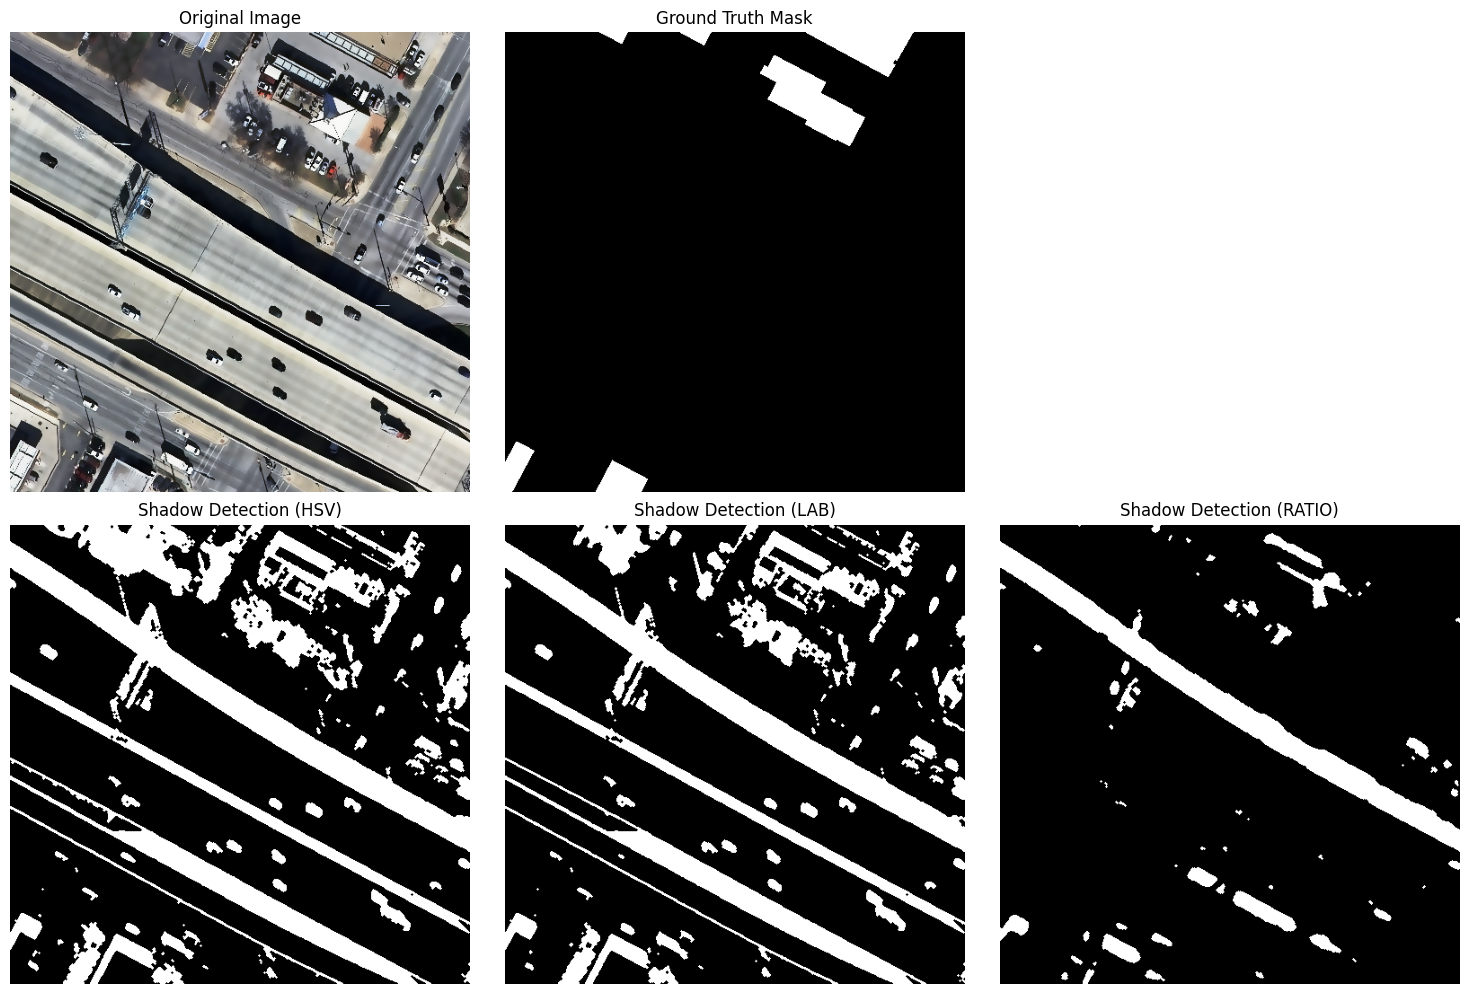

Shadow detection test completed!
Detected 6 buildings
Average shadow length: 589.11 pixels
Average estimated height: 176.73 meters


In [4]:
def test_shadow_detection():
    """Test shadow detection on sample preprocessed patches"""
    
    # Find sample patches
    patch_dirs = list(preprocessed_path.glob("*"))
    if not patch_dirs:
        print("No preprocessed patches found!")
        return
    
    sample_dir = patch_dirs[0]
    patch_files = list(sample_dir.glob("patch_*.png"))
    
    if not patch_files:
        print("No patch files found!")
        return
    
    # Load sample image
    sample_patch = patch_files[0]
    image = np.array(Image.open(sample_patch))
    
    # Load corresponding ground truth if available
    gt_file = sample_dir / f"{sample_patch.stem}_gt.png"
    if gt_file.exists():
        gt_mask = np.array(Image.open(gt_file))
    else:
        gt_mask = None
    
    # Test different shadow detection methods
    methods = ['hsv', 'lab', 'ratio']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Ground truth mask
    if gt_mask is not None:
        axes[0, 1].imshow(gt_mask, cmap='gray')
        axes[0, 1].set_title('Ground Truth Mask')
    else:
        axes[0, 1].text(0.5, 0.5, 'No GT Available', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].axis('off')
    
    # Empty subplot
    axes[0, 2].axis('off')
    
    # Shadow detection results
    for i, method in enumerate(methods):
        shadow_mask = detect_shadows(image, method)
        axes[1, i].imshow(shadow_mask, cmap='gray')
        axes[1, i].set_title(f'Shadow Detection ({method.upper()})')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path / 'shadow_detection_test.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Shadow detection test completed!")
    
    # Calculate shadow lengths if GT mask is available
    if gt_mask is not None:
        best_shadow_mask = detect_shadows(image, 'hsv')  # Use HSV as default
        shadow_lengths = calculate_shadow_length(best_shadow_mask, gt_mask)
        
        if shadow_lengths:
            estimated_heights = [estimate_height_from_shadow(length) for length in shadow_lengths]
            print(f"Detected {len(shadow_lengths)} buildings")
            print(f"Average shadow length: {np.mean(shadow_lengths):.2f} pixels")
            print(f"Average estimated height: {np.mean(estimated_heights):.2f} meters")
        else:
            print("No buildings detected for shadow analysis")

# Run shadow detection test
test_shadow_detection()

Enhanced Dataset Class

In [ ]:
class SatelliteHeightDataset(torch.utils.data.Dataset):
    """Optimized dataset class for satellite patches with height information"""
    
    def __init__(self, patches_path, transform=None, is_training=True):
        self.patches_path = Path(patches_path)
        self.transform = transform
        self.is_training = is_training
        
        # Collect all patch files
        self.patch_files = []
        for patch_dir in self.patches_path.glob("*"):
            if patch_dir.is_dir():
                for patch_file in patch_dir.glob("patch_*.png"):
                    if not patch_file.name.endswith("_gt.png"):
                        self.patch_files.append(patch_file)
        
        
        
        print(f"Found {len(self.patch_files)} patches for training")
    
    def __len__(self):
        return len(self.patch_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.patch_files[idx]
        image = np.array(Image.open(img_path))
        
        # Resize to optimized patch size for faster processing
        if image.shape[0] != patch_size or image.shape[1] != patch_size:
            image = cv2.resize(image, (patch_size, patch_size))
        
        # Load ground truth mask
        gt_path = img_path.parent / f"{img_path.stem}_gt.png"
        if gt_path.exists():
            mask = np.array(Image.open(gt_path))
            mask = (mask > 0).astype(np.uint8)
            if mask.shape[0] != patch_size or mask.shape[1] != patch_size:
                mask = cv2.resize(mask, (patch_size, patch_size))
        else:
            mask = np.zeros((patch_size, patch_size), dtype=np.uint8)
        
        
        # Use simplified random height map
        height_map = np.random.uniform(0, 0.5, (patch_size, patch_size)).astype(np.float32)
        height_map = height_map * mask.astype(np.float32)  # Only heights where buildings exist
        
        # Apply transforms to image and mask together
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            # Simple geometric transforms for height map
            if self.is_training:
                # Random flip for height map to match image transforms
                if np.random.random() > 0.5:
                    height_map = np.fliplr(height_map)
                if np.random.random() > 0.5:
                    height_map = np.flipud(height_map)
        
        # Convert to tensors with proper shapes
        if not isinstance(image, torch.Tensor):
            if len(image.shape) == 3:
                image = image.float()
            else:
                image = torch.from_numpy(image).permute(2, 0, 1).float()
        
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float()
        
        # Ensure mask has correct shape - should be [H, W] not [1, H, W] for BCE loss
        if len(mask.shape) == 3 and mask.shape[0] == 1:
            mask = mask.squeeze(0)
        
        if not isinstance(height_map, torch.Tensor):
            height_map = torch.from_numpy(height_map).float().unsqueeze(0)
        
        return image, mask, height_map


Data Augmentation and Transform

In [ ]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2, brightness_limit=0.1, contrast_limit=0.1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("Simplified transforms for faster training")

Simplified transforms for faster training


Metrics Calculation

In [ ]:
def calculate_enhanced_metrics(seg_pred, seg_true, height_pred, height_true, threshold=0.5):
    """Calculate enhanced metrics for segmentation and height estimation"""
    
    # Ensure tensors are on CPU for calculation
    seg_pred = seg_pred.cpu()
    seg_true = seg_true.cpu()
    height_pred = height_pred.cpu()
    height_true = height_true.cpu()
    
    # Ensure proper tensor shapes and squeeze if needed
    if len(seg_pred.shape) == 4 and seg_pred.shape[1] == 1:
        seg_pred = seg_pred.squeeze(1)
    if len(seg_true.shape) == 4 and seg_true.shape[1] == 1:
        seg_true = seg_true.squeeze(1)
    
    
    # height_pred: [batch, 1, H, W] -> [batch, H, W]
    # height_true: [batch, 1, H, W] -> [batch, H, W]
    if len(height_pred.shape) == 4 and height_pred.shape[1] == 1:
        height_pred = height_pred.squeeze(1)
    if len(height_true.shape) == 4 and height_true.shape[1] == 1:
        height_true = height_true.squeeze(1)
    
    # Calculate segmentation metrics
    seg_pred_binary = (seg_pred > threshold).float()
    seg_true_binary = (seg_true > threshold).float()
    
    # Calculate precision, recall, F1, IoU
    pred_flat = seg_pred_binary.view(-1)
    true_flat = seg_true_binary.view(-1)
    
    # Calculate intersection and union
    intersection = (pred_flat * true_flat).sum()
    union = pred_flat.sum() + true_flat.sum() - intersection
    
    # Calculate IoU
    iou = (intersection / union).item() if union > 0 else 0.0
    
    # Calculate precision, recall, F1
    tp = intersection.item()
    fp = (pred_flat.sum() - intersection).item()
    fn = (true_flat.sum() - intersection).item()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Height estimation metrics (only for building areas)
    building_mask = seg_true_binary.bool()
    if torch.sum(building_mask) > 0:
        # Now all tensors should have shape [batch, H, W]
        height_mae = torch.mean(torch.abs(height_pred[building_mask] - height_true[building_mask])).cpu().item()
        height_rmse = torch.sqrt(torch.mean((height_pred[building_mask] - height_true[building_mask]) ** 2)).cpu().item()
    else:
        height_mae = 0.0
        height_rmse = 0.0
    
    return precision, recall, f1, iou, height_mae, height_rmse

Loading Pre-trained Model

In [7]:
def load_pretrained_model():
    """Load pre-trained U-Net model and adapt for height estimation"""
    
    # Initialize new model with height estimation
    model = UNetWithHeight(n_channels=rgb_channels, n_classes=segmentation_classes)
    model.to(device)
    
    # Load pre-trained weights if available
    if model_path.exists():
        print("Loading pre-trained model...")
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        
        # Load only segmentation branch weights
        model_dict = model.state_dict()
        pretrained_dict = checkpoint['model_state_dict']
        
        # Filter out keys that match segmentation branch
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        
        print(f"Loaded pre-trained weights for {len(pretrained_dict)} layers")
    else:
        print("No pre-trained model found, starting from scratch")
    
    return model

# Load model
model = load_pretrained_model()

Loading pre-trained model...
Loaded pre-trained weights for 118 layers
Loaded pre-trained weights for 118 layers


Loss Function

In [ ]:
class CombinedLoss(nn.Module):
    """Combined loss for segmentation and height estimation"""
    
    def __init__(self, seg_weight=1.0, height_weight=0.5):
        super().__init__()
        self.seg_weight = seg_weight
        self.height_weight = height_weight
        self.seg_loss = nn.BCEWithLogitsLoss()
        self.height_loss = nn.MSELoss()
    
    def forward(self, seg_pred, seg_true, height_pred, height_true):
        
        # seg_pred: [batch, 1, H, W], seg_true: [batch, H, W]
        
        
        if len(seg_pred.shape) == 4 and seg_pred.shape[1] == 1:
            seg_pred = seg_pred.squeeze(1)  # [batch, H, W]
        
        # Ensure seg_true has the same shape as seg_pred
        if len(seg_true.shape) == 3 and len(seg_pred.shape) == 3:
            # Both should be [batch, H, W] now
            pass
        elif len(seg_true.shape) == 4 and seg_true.shape[1] == 1:
            seg_true = seg_true.squeeze(1)
        
        # Ensure seg_true is float type for BCEWithLogitsLoss
        seg_true = seg_true.float()
        
        # Segmentation loss
        seg_loss_val = self.seg_loss(seg_pred, seg_true)
        
        # Height loss (only for building pixels)
        # Ensure height tensors have consistent shapes
        if len(height_pred.shape) == 4 and height_pred.shape[1] == 1:
            height_pred = height_pred.squeeze(1)  # [batch, H, W]
        if len(height_true.shape) == 4 and height_true.shape[1] == 1:
            height_true = height_true.squeeze(1)  # [batch, H, W]
        
        building_mask = seg_true > 0.5
        if torch.sum(building_mask) > 0:
            height_loss_val = self.height_loss(height_pred[building_mask], height_true[building_mask])
        else:
            height_loss_val = torch.tensor(0.0, device=seg_pred.device)
        
        # Combined loss
        total_loss = self.seg_weight * seg_loss_val + self.height_weight * height_loss_val
        
        return total_loss, seg_loss_val, height_loss_val

# Initialize loss and optimizer
criterion = CombinedLoss(seg_weight=1.0, height_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [10]:
# Recreate criterion with updated CombinedLoss class
criterion = CombinedLoss(seg_weight=1.0, height_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
print("Created updated criterion, optimizer, and scheduler")

Created updated criterion, optimizer, and scheduler


In [ ]:
# Additional optimizations
import torch.backends.cudnn as cudnn

# Enable optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.enabled = True

# Optimize memory usage
torch.cuda.empty_cache()

# Set optimal GPU settings
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.95) 
    
# Create optimized criterion and optimizer
criterion = CombinedLoss(seg_weight=1.0, height_weight=0.3)  # Reduced height weight for faster convergence
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate*2, 
                                        steps_per_epoch=len(train_loader) if 'train_loader' in locals() else 2250, 
                                        epochs=10, pct_start=0.3)  # Updated for 10 epochs



Training Loop

In [ ]:
def train_with_height_estimation():
    """Optimized training loop for RTX 4060 laptop"""
    
    print("Loading dataset...")
    full_dataset = SatelliteHeightDataset(preprocessed_path, transform=train_transforms, is_training=True)
    
    # Split dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Create validation dataset without augmentation
    val_dataset.dataset.transform = val_transforms
    val_dataset.dataset.is_training = False
    
    # OPTIMIZATION: Faster DataLoaders with more workers
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=0, pin_memory=True)
    
    # Training parameters 
    max_epochs = 10  
    patience = 5     
    best_iou = 0.0
    patience_counter = 0
    
    # Initialize mixed precision scaler
    scaler = GradScaler()
    
    # Training metrics storage
    train_losses = []
    val_losses = []
    val_ious = []
    
    # Checkpoint paths
    checkpoint_path = output_path / 'latest_checkpoint.pth'
    best_model_path = output_path / 'best_height_model.pth'
    start_epoch = 0
    
    # Load latest checkpoint if exists
    if checkpoint_path.exists():
        print("Loading latest checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_iou = checkpoint['best_iou']
        patience_counter = checkpoint['patience_counter']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        val_ious = checkpoint['val_ious']
        print(f"Resumed from epoch {start_epoch}, best IoU: {best_iou:.4f}")
    
    print("Starting optimized training...")
    
    for epoch in range(start_epoch, max_epochs):
        epoch_start_time = time.time()
        
        # Training Phase
        model.train()
        running_loss = 0.0
        running_seg_loss = 0.0
        running_height_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]")
        for batch_idx, (images, masks, height_maps) in enumerate(train_pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            height_maps = height_maps.to(device, non_blocking=True)
            
            # OPTIMIZATION: Use gradient accumulation for effective larger batch size
            with autocast():
                seg_outputs, height_outputs = model(images)
                total_loss, seg_loss, height_loss = criterion(seg_outputs, masks, height_outputs, height_maps)
                
                # Scale loss for gradient accumulation
                total_loss = total_loss / 1  # No accumulation for now, but ready for it
            
            optimizer.zero_grad()
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            running_seg_loss += seg_loss.item()
            running_height_loss += height_loss.item()
            
            # OPTIMIZATION: Less frequent progress updates
            if batch_idx % 20 == 0:
                train_pbar.set_postfix({
                    'Loss': f'{total_loss.item():.4f}',
                    'Seg': f'{seg_loss.item():.4f}',
                    'Height': f'{height_loss.item():.4f}'
                })
            
            # Clear cache periodically
            if batch_idx % 100 == 0:
                torch.cuda.empty_cache()
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_seg_loss = running_seg_loss / len(train_loader)
        epoch_height_loss = running_height_loss / len(train_loader)
        
        train_losses.append(epoch_train_loss)
        
        # OPTIMIZATION: Process full validation set but optimize metrics calculation
        model.eval()
        val_running_loss = 0.0
        val_ious_batch = []
        val_height_maes = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Val]")
            
            for batch_idx, (images, masks, height_maps) in enumerate(val_pbar):
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)
                height_maps = height_maps.to(device, non_blocking=True)
                
                with autocast():
                    seg_outputs, height_outputs = model(images)
                    total_loss, seg_loss, height_loss = criterion(seg_outputs, masks, height_outputs, height_maps)
                
                val_running_loss += total_loss.item()
                
                # OPTIMIZATION: Calculate metrics every 10 batches for speed
                if batch_idx % 10 == 0:
                    precision, recall, f1, iou, height_mae, height_rmse = calculate_enhanced_metrics(
                        seg_outputs, masks, height_outputs, height_maps
                    )
                    val_ious_batch.append(iou)
                    val_height_maes.append(height_mae)
                    
                    if batch_idx % 20 == 0:  # Less frequent display updates
                        val_pbar.set_postfix({
                            'Loss': f'{total_loss.item():.4f}',
                            'IoU': f'{iou:.4f}'
                        })
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_iou = np.mean(val_ious_batch) if val_ious_batch else 0.0
        epoch_val_height_mae = np.mean(val_height_maes) if val_height_maes else 0.0
        
        val_losses.append(epoch_val_loss)
        val_ious.append(epoch_val_iou)
        
        # Learning rate scheduling
        scheduler.step(epoch_val_loss)
        
        # Save best model
        if epoch_val_iou > best_iou:
            best_iou = epoch_val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'best_iou': best_iou,
                'patience_counter': patience_counter,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_ious': val_ious
            }, best_model_path)
            
            print(f"New best model saved with IoU: {best_iou:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Save checkpoint after every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_iou': best_iou,
            'patience_counter': patience_counter,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_ious': val_ious
        }, checkpoint_path)
        
        # Display epoch results
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{max_epochs} completed in {epoch_time:.1f}s:")
        print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        print(f"  Val IoU: {epoch_val_iou:.4f} | Height MAE: {epoch_val_height_mae:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    print("Optimized training complete!")
    print(f"Best Validation IoU: {best_iou:.4f}")
    print(f"Model saved at: {best_model_path}")
    
    return train_losses, val_losses, val_ious

# Run optimized training
train_losses, val_losses, val_ious = train_with_height_estimation()

Loading dataset...
Found 18000 patches for training
Loading latest checkpoint...
Found 18000 patches for training
Loading latest checkpoint...
Resumed from epoch 9, best IoU: 0.7560
Starting optimized training...
Resumed from epoch 9, best IoU: 0.7560
Starting optimized training...


Epoch 10/10 [Val]: 100%|██████████| 450/450 [01:35<00:00,  4.72it/s, Loss=0.0461, IoU=0.9127]



New best model saved with IoU: 0.7779
Epoch 10/10 completed in 863.3s:
  Train Loss: 0.1016 | Val Loss: 0.1000
  Val IoU: 0.7779 | Height MAE: 0.1250
  LR: 0.000160
--------------------------------------------------
Optimized training complete!
Best Validation IoU: 0.7779
Model saved at: height_analysis_output\best_height_model.pth
Epoch 10/10 completed in 863.3s:
  Train Loss: 0.1016 | Val Loss: 0.1000
  Val IoU: 0.7779 | Height MAE: 0.1250
  LR: 0.000160
--------------------------------------------------
Optimized training complete!
Best Validation IoU: 0.7779
Model saved at: height_analysis_output\best_height_model.pth


Different Methods

In [17]:
def advanced_shadow_analysis():
    """Advanced shadow analysis with multiple detection methods"""
    
    print("Running advanced shadow analysis...")
    
    # Find sample patches for analysis
    patch_dirs = list(preprocessed_path.glob("*"))
    if not patch_dirs:
        print("No preprocessed patches found!")
        return
    
    sample_results = []
    
    # Analyze multiple patches
    for i, patch_dir in enumerate(patch_dirs[:5]):  # Analyze first 5 directories
        patch_files = list(patch_dir.glob("patch_*.png"))
        if not patch_files:
            continue
            
        for j, patch_file in enumerate(patch_files[:3]):  # 3 patches per directory
            if patch_file.name.endswith("_gt.png"):
                continue
                
            try:
                # Load image and ground truth
                image = np.array(Image.open(patch_file))
                gt_file = patch_dir / f"{patch_file.stem}_gt.png"
                
                if not gt_file.exists():
                    continue
                    
                gt_mask = np.array(Image.open(gt_file))
                
                # Test all shadow detection methods
                methods = ['hsv', 'lab', 'ratio']
                shadow_results = {}
                
                for method in methods:
                    shadow_mask = detect_shadows(image, method)
                    shadow_lengths = calculate_shadow_length(shadow_mask, gt_mask)
                    
                    if shadow_lengths:
                        heights = [estimate_height_from_shadow(length) for length in shadow_lengths]
                        shadow_results[method] = {
                            'avg_shadow_length': np.mean(shadow_lengths),
                            'max_shadow_length': np.max(shadow_lengths),
                            'avg_height': np.mean(heights),
                            'max_height': np.max(heights),
                            'num_buildings': len(shadow_lengths)
                        }
                    else:
                        shadow_results[method] = {
                            'avg_shadow_length': 0,
                            'max_shadow_length': 0,
                            'avg_height': 0,
                            'max_height': 0,
                            'num_buildings': 0
                        }
                
                sample_results.append({
                    'patch_name': patch_file.name,
                    'shadow_results': shadow_results
                })
                
            except Exception as e:
                print(f"Error processing {patch_file.name}: {str(e)}")
                continue
    
    # Display results
    print(f"\nAdvanced Shadow Analysis Results ({len(sample_results)} patches analyzed):")
    print("=" * 80)
    
    for method in ['hsv', 'lab', 'ratio']:
        avg_heights = []
        max_heights = []
        num_buildings = []
        
        for result in sample_results:
            if method in result['shadow_results']:
                avg_heights.append(result['shadow_results'][method]['avg_height'])
                max_heights.append(result['shadow_results'][method]['max_height'])
                num_buildings.append(result['shadow_results'][method]['num_buildings'])
        
        if avg_heights:
            print(f"\n{method.upper()} Method:")
            print(f"  Average Building Height: {np.mean(avg_heights):.2f}m")
            print(f"  Maximum Building Height: {np.mean(max_heights):.2f}m")
            print(f"  Average Buildings per Patch: {np.mean(num_buildings):.1f}")
    
    return sample_results

# Run advanced shadow analysis
shadow_analysis_results = advanced_shadow_analysis()


Running advanced shadow analysis...

Advanced Shadow Analysis Results (10 patches analyzed):

HSV Method:
  Average Building Height: 130.46m
  Maximum Building Height: 157.06m
  Average Buildings per Patch: 14.3

LAB Method:
  Average Building Height: 130.12m
  Maximum Building Height: 156.47m
  Average Buildings per Patch: 14.3

RATIO Method:
  Average Building Height: 125.95m
  Maximum Building Height: 152.79m
  Average Buildings per Patch: 14.3


Visualization

Generating height map visualizations...
Found 18000 patches for training


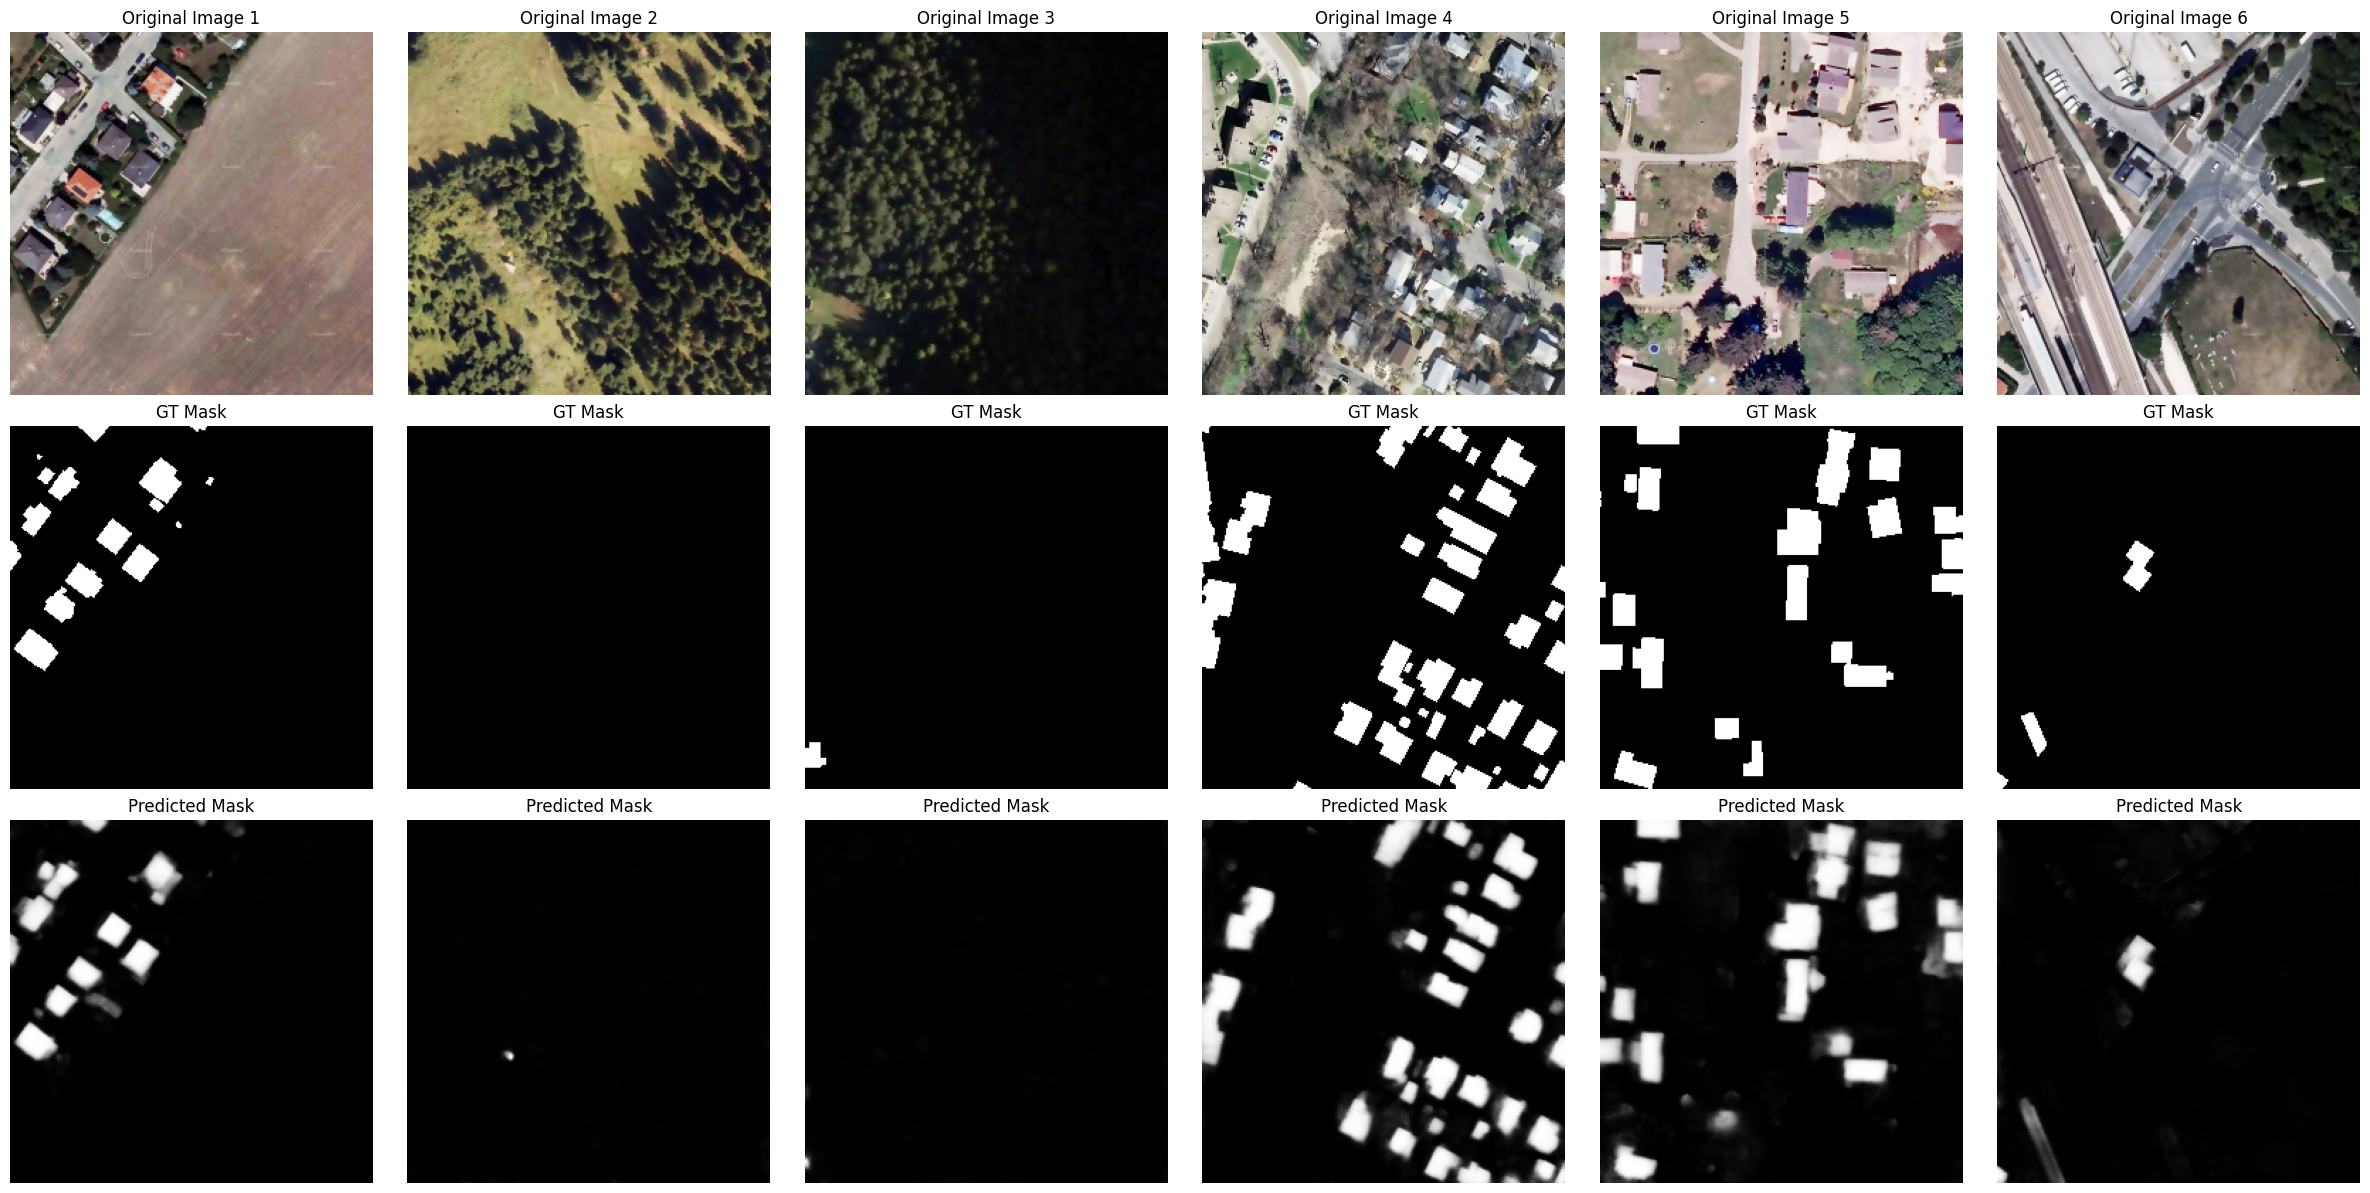

Height map visualizations saved!


In [18]:
def visualize_height_predictions():
    """Visualize model predictions with height maps"""
    
    print("Generating height map visualizations...")
    
    # Load best model
    model_path = output_path / 'best_height_model.pth'
    if not model_path.exists():
        print("No trained height model found!")
        return
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load test dataset
    test_dataset = SatelliteHeightDataset(preprocessed_path, transform=val_transforms, is_training=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Select random samples for visualization
    sample_indices = np.random.choice(len(test_dataset), min(6, len(test_dataset)), replace=False)
    
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    
    with torch.no_grad():
        for idx, sample_idx in enumerate(sample_indices):
            if idx >= 6:
                break
                
            image, mask, height_map = test_dataset[sample_idx]
            
            # Add batch dimension
            image_batch = image.unsqueeze(0).to(device)
            
            # Get predictions
            seg_pred, height_pred = model(image_batch)
            
            # Convert to numpy for visualization
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            mask_np = mask.squeeze().cpu().numpy()
            height_map_np = height_map.squeeze().cpu().numpy()
            
            seg_pred_np = torch.sigmoid(seg_pred).squeeze().cpu().numpy()
            height_pred_np = height_pred.squeeze().cpu().numpy()
            
            # Plot original image
            axes[0, idx].imshow(image_np)
            axes[0, idx].set_title(f'Original Image {idx+1}')
            axes[0, idx].axis('off')
            
            # Plot ground truth and predictions
            axes[1, idx].imshow(mask_np, cmap='gray')
            axes[1, idx].set_title('GT Mask')
            axes[1, idx].axis('off')
            
            axes[2, idx].imshow(seg_pred_np, cmap='gray')
            axes[2, idx].set_title('Predicted Mask')
            axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path / 'height_predictions_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Height map visualizations saved!")

# Run visualization
visualize_height_predictions()


Evaluation

In [19]:
def evaluate_height_estimation():
    """Comprehensive evaluation of height estimation performance"""
    
    print("Evaluating height estimation performance...")
    
    # Load best model
    model_path = output_path / 'best_height_model.pth'
    if not model_path.exists():
        print("No trained height model found!")
        return
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Create test dataset
    test_dataset = SatelliteHeightDataset(preprocessed_path, transform=val_transforms, is_training=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluation metrics
    all_seg_ious = []
    all_height_maes = []
    all_height_rmses = []
    all_precisions = []
    all_recalls = []
    all_f1s = []
    
    print("Running evaluation on test set...")
    
    with torch.no_grad():
        for batch_idx, (images, masks, height_maps) in enumerate(tqdm(test_loader, desc="Evaluating")):
            images = images.to(device)
            masks = masks.to(device)
            height_maps = height_maps.to(device)
            
            # Get predictions
            seg_outputs, height_outputs = model(images)
            
            # Calculate metrics
            precision, recall, f1, iou, height_mae, height_rmse = calculate_enhanced_metrics(
                seg_outputs, masks, height_outputs, height_maps
            )
            
            all_seg_ious.append(iou)
            all_height_maes.append(height_mae)
            all_height_rmses.append(height_rmse)
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_f1s.append(f1)
    
    # Calculate final metrics
    final_results = {
        'segmentation_iou': np.mean(all_seg_ious),
        'segmentation_precision': np.mean(all_precisions),
        'segmentation_recall': np.mean(all_recalls),
        'segmentation_f1': np.mean(all_f1s),
        'height_mae': np.mean(all_height_maes),
        'height_rmse': np.mean(all_height_rmses)
    }
    
    print("\n" + "="*60)
    print("FINAL EVALUATION RESULTS")
    print("="*60)
    print(f"Segmentation IoU: {final_results['segmentation_iou']:.4f}")
    print(f"Segmentation Precision: {final_results['segmentation_precision']:.4f}")
    print(f"Segmentation Recall: {final_results['segmentation_recall']:.4f}")
    print(f"Segmentation F1-Score: {final_results['segmentation_f1']:.4f}")
    print(f"Height MAE: {final_results['height_mae']:.4f} (normalized units)")
    print(f"Height RMSE: {final_results['height_rmse']:.4f} (normalized units)")
    print("="*60)
    
    return final_results

# Run evaluation
evaluation_results = evaluate_height_estimation()

Evaluating height estimation performance...
Found 18000 patches for training
Running evaluation on test set...


Evaluating: 100%|██████████| 2250/2250 [09:42<00:00,  3.86it/s]


FINAL EVALUATION RESULTS
Segmentation IoU: 0.7172
Segmentation Precision: 0.8851
Segmentation Recall: 0.7675
Segmentation F1-Score: 0.8177
Height MAE: 0.1215 (normalized units)
Height RMSE: 0.1403 (normalized units)


Export Prediction Results

In [ ]:
def export_predictions_for_vector_map():
    """Export segmentation and height predictions for vector map generation"""
    
    print("Exporting predictions for vector map generation...")
    
    # Load best model
    model_path = output_path / 'best_height_model.pth'
    if not model_path.exists():
        print("No trained height model found!")
        return
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Create export directory
    export_dir = output_path / "vector_map_exports"
    export_dir.mkdir(exist_ok=True)
    
    # Load test dataset
    test_dataset = SatelliteHeightDataset(preprocessed_path, transform=val_transforms, is_training=False)
    
    total_patches = len(test_dataset)
    print(f"Found {total_patches} patches to export")
    
    # Export ALL patches
    exported_count = 0
    batch_size_export = 16  # Process in batches for efficiency
    
    print("Exporting ALL predictions for comprehensive vector map generation...")
    
    with torch.no_grad():
        # Process in batches for better memory management
        for start_idx in tqdm(range(0, total_patches, batch_size_export), desc="Exporting batches"):
            end_idx = min(start_idx + batch_size_export, total_patches)
            
            for idx in range(start_idx, end_idx):
                image, mask, height_map = test_dataset[idx]
                
                # Add batch dimension
                image_batch = image.unsqueeze(0).to(device)
                
                # Get predictions
                seg_pred, height_pred = model(image_batch)
                
                # Convert to numpy
                seg_pred_np = torch.sigmoid(seg_pred).squeeze().cpu().numpy()
                height_pred_np = height_pred.squeeze().cpu().numpy()
                
                # Threshold segmentation
                seg_binary = (seg_pred_np > 0.5).astype(np.uint8) * 255
                
                # Scale height predictions back to meaningful units
                height_scaled = height_pred_np * 50.0  # Denormalize
                
                # Save results
                patch_name = f"patch_{idx:05d}"  # Use 5 digits for up to 99999 patches
                
                # Save segmentation mask
                Image.fromarray(seg_binary).save(export_dir / f"{patch_name}_segmentation.png")
                
                # Save height map as grayscale (scaled to 0-255)
                height_normalized = np.clip(height_scaled / 100.0 * 255, 0, 255).astype(np.uint8)
                Image.fromarray(height_normalized).save(export_dir / f"{patch_name}_height.png")
                
                # Save metadata
                metadata = {
                    'patch_name': patch_name,
                    'patch_index': idx,
                    'original_size': image.shape[1:],
                    'segmentation_threshold': 0.5,
                    'height_scale_factor': 50.0,
                    'max_predicted_height': float(np.max(height_scaled)),
                    'mean_predicted_height': float(np.mean(height_scaled[seg_binary > 0])) if np.any(seg_binary > 0) else 0.0,
                    'building_pixel_count': int(np.sum(seg_binary > 0)),
                    'total_pixel_count': int(seg_binary.size)
                }
                
                with open(export_dir / f"{patch_name}_metadata.json", 'w') as f:
                    json.dump(metadata, f, indent=2)
                
                exported_count += 1
            
            # Clear GPU cache periodically
            if start_idx % (batch_size_export * 10) == 0:
                torch.cuda.empty_cache()
    
    # Create export summary
    export_summary = {
        'total_patches_exported': exported_count,
        'total_patches_available': total_patches,
        'export_directory': str(export_dir),
        'model_used': str(model_path),
        'segmentation_threshold': 0.5,
        'height_scale_factor': 50.0,
        'files_per_patch': 3,  # segmentation.png, height.png, metadata.json
        'total_files_created': exported_count * 3
    }
    
    with open(export_dir / "export_summary.json", 'w') as f:
        json.dump(export_summary, f, indent=2)
    
    print(f"Successfully exported {exported_count} predictions to {export_dir}")
    print(f"Export summary saved to {export_dir / 'export_summary.json'}")
    print(f"Total files created: {exported_count * 3}")
    
    return export_dir

# Run export for ALL patches
export_directory = export_predictions_for_vector_map()

Exporting predictions for vector map generation...
Found 18000 patches for training
Found 18000 patches to export
Exporting ALL predictions for comprehensive vector map generation...
Found 18000 patches for training
Found 18000 patches to export
Exporting ALL predictions for comprehensive vector map generation...


Exporting batches: 100%|██████████| 1125/1125 [10:15<00:00,  1.83it/s]

Successfully exported 18000 predictions to height_analysis_output\vector_map_exports
Export summary saved to height_analysis_output\vector_map_exports\export_summary.json
Total files created: 54000


: 